In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.8 MB/s eta 0:00:00


In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from catboost import CatBoostRegressor, Pool


import warnings; warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Открываем файл
try:
    train_df = pd.read_csv('train_dataset.csv')
except:
    train_df = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/train_dataset.csv')

try:
    test_df = pd.read_csv('test_dataset.csv')
except:
    test_df = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/test_dataset.csv')

In [6]:
train_df['date'] = pd.to_datetime(train_df['date']).dt.normalize()
df = pd.concat([train_df, test_df])[['date', 'time', 'target', 'temp_pred', 'weather_pred', 'temp']]

In [7]:
df.shape

(40152, 6)

In [8]:
#add features of day-of-week, day-of-month, week, month, season
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df['dow'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype('int32')
df['month'] = df['date'].dt.month
df['season'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

In [9]:
#add lag columns
shifted = df.copy()

for i in range(24, (24*21+1), 24):
    shifted[f'target_lag_{int(i/24)}'] = shifted['target'].shift(i)
shifted.head()

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,target_lag_12,target_lag_13,target_lag_14,target_lag_15,target_lag_16,target_lag_17,target_lag_18,target_lag_19,target_lag_20,target_lag_21
0,2019-01-01,0,481.510,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,1,462.872,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,2,449.718,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,3,430.908,2.0,"пасм, ветер",4.3,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,4,415.163,2.0,"пасм, ветер",4.3,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#add lag columns for temp
for i in range(24, (24*4+1), 24):
    shifted[f'temp_lag_{int(i/24)}'] = shifted['temp'].shift(i)

shifted['diff_temp'] = shifted['temp_pred'] - shifted['temp_lag_1']
shifted.head()

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,target_lag_17,target_lag_18,target_lag_19,target_lag_20,target_lag_21,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,diff_temp
0,2019-01-01,0,481.510,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,1,462.872,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,2,449.718,2.0,"пасм, ветер",2.9,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,3,430.908,2.0,"пасм, ветер",4.3,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,4,415.163,2.0,"пасм, ветер",4.3,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#delete nans where there's no lag data (start of period)
shifted['na_sum'] = shifted.isna().sum(axis=1)
shifted = shifted[shifted['na_sum'] == 0]
shifted = shifted.drop('na_sum', axis=1)
shifted.shape

(39536, 38)

In [12]:
bad_weathers = {'пасм': 'overcast', 'дожд': 'rain', 'снег': 'snow', 'ливень': 'heavy_rain', 'гроз': 'thunder', 'шторм': 'storm'}
for weather_type in bad_weathers.keys():
    shifted[bad_weathers[weather_type]] = np.where(shifted['weather_pred'].str.contains(weather_type), 1, 0)

shifted['cloudy'] = np.where((shifted['weather_pred'].str.contains(' обл')) | (shifted['weather_pred'].str.startswith('обл')), 1, 0)

In [14]:
try:
    daylight = pd.read_csv('light_day.csv')
except:
    daylight = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/light_day.csv')

In [15]:
daylight = daylight.rename(columns={'Дата': 'date', 'Восход': 'sunrise', 'Заход': 'sunset'})
daylight = daylight[['date', 'sunrise', 'sunset']]
daylight['date'] = pd.to_datetime(daylight['date']).dt.normalize()
daylight['day'] = daylight['date'].dt.day
daylight['month'] = daylight['date'].dt.month
daylight['sunrise'] = daylight['sunrise'].str.replace(':', '.').str.lstrip('0').astype('float')
daylight['sunset'] = daylight['sunset'].str.replace(':', '.').str.lstrip('0').astype('float')
daylight = daylight[['day', 'month', 'sunrise', 'sunset']]
daylight.dtypes


day          int64
month        int64
sunrise    float64
sunset     float64
dtype: object

In [16]:
with_daylight = shifted.merge(daylight, on=['month', 'day'], how='left')
with_daylight.shape

(39536, 47)

In [17]:
with_daylight['light'] = np.where((with_daylight['time'] >= with_daylight['sunrise']) &
                                  (with_daylight['time'] <= with_daylight['sunset']), 1, 0)
with_daylight.sample(5)

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,overcast,rain,snow,heavy_rain,thunder,storm,cloudy,sunrise,sunset,light
4891,2019-08-13,19,454.083,17.0,"п/обл, ветер",16.3,1,13,33,8,...,0,0,0,0,0,0,0,5.07,20.17,1
20791,2021-06-06,15,428.519,21.0,п/обл,21.6,6,6,22,6,...,0,0,0,0,0,0,0,4.04,21.08,1
6952,2019-11-07,16,572.652,6.0,обл с проясн,6.7,3,7,45,11,...,0,0,0,0,0,0,1,7.50,16.51,1
4537,2019-07-30,1,341.007,18.0,"обл., возм.дождь",20.2,1,30,31,7,...,0,1,0,0,0,0,1,4.42,20.45,0
7768,2019-12-11,16,620.604,0.0,п/обл,-0.2,2,11,50,12,...,0,0,0,0,0,0,0,8.49,16.11,1


In [18]:
with_daylight['dark_weather'] = np.where((with_daylight['light'] == 1) &
                                  (with_daylight[['rain', 'heavy_rain', 'thunder', 'storm', 'snow', 'overcast', 'cloudy']].any(axis='columns') == 1), 1, 0)
with_daylight.sample(5)

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,rain,snow,heavy_rain,thunder,storm,cloudy,sunrise,sunset,light,dark_weather
2625,2019-05-11,9,408.961,14.0,п/обл,13.6,5,11,19,5,...,0,0,0,0,0,0,4.41,20.29,1,0
16147,2020-11-24,19,617.589,6.0,"проясн, 40% ?",5.9,1,24,48,11,...,0,0,0,0,0,0,8.23,16.24,0,0
14960,2020-10-06,8,404.583,13.0,"обл с пр, 24%",11.4,1,6,41,10,...,0,0,0,0,0,1,6.47,18.04,1,1
3466,2019-06-15,10,417.479,23.0,п/обл,23.1,5,15,24,6,...,0,0,0,0,0,0,4.00,21.16,1,0
36916,2023-04-12,20,518.529,7.0,ясно,11.1,2,12,15,4,...,0,0,0,0,0,0,5.45,19.33,0,0


In [19]:
with_ma = with_daylight.copy()

for i in range(2, 8):
    with_ma[f'ma_{int(i)}'] = with_ma[[f'target_lag_{j}' for j in range(1, i)]].mean(axis=1)
    with_ma[f'mm_{int(i)}'] = with_ma[[f'target_lag_{j}' for j in range(1, i)]].median(axis=1)

with_ma.head()

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,ma_3,mm_3,ma_4,mm_4,ma_5,mm_5,ma_6,mm_6,ma_7,mm_7
0,2019-01-22,0,546.601,-2.0,пасмурно,-3.7,1,22,4,1,...,535.0200,535.0200,538.435333,536.856,535.55575,535.0200,534.9548,533.184,536.452667,535.0200
1,2019-01-22,1,508.166,-2.0,пасмурно,-3.7,1,22,4,1,...,500.0425,500.0425,503.611333,502.079,500.30550,500.0425,499.3870,498.006,499.823667,500.0065
2,2019-01-22,2,485.543,-2.0,пасмурно,-3.7,1,22,4,1,...,476.3255,476.3255,478.891000,478.040,476.13875,476.3255,474.9476,474.611,475.832833,476.3255
3,2019-01-22,3,473.236,-3.0,пасмурно,-3.9,1,22,4,1,...,464.3360,464.3360,465.919333,464.489,463.36125,464.3360,462.9282,464.183,463.779333,464.3360
4,2019-01-22,4,467.938,-3.0,пасмурно,-3.9,1,22,4,1,...,457.1320,457.1320,458.579333,457.621,456.47775,457.1320,456.0934,456.643,457.105000,457.1320


In [20]:
# mark days-off

try:
    c19 = pd.read_csv('calendar2019.csv')
except:
    c19 = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/calendar2019.csv')

try:
    c20 = pd.read_csv('calendar2020.csv')
except:
    c20 = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/calendar2020.csv')

try:
    c21 = pd.read_csv('calendar2021.csv')
except:
    c21 = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/calendar2021.csv')

try:
    c22 = pd.read_csv('calendar2022.csv')
except:
    c22 = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/calendar2022.csv')

try:
    c23 = pd.read_csv('calendar2023.csv')
except:
    c23 = pd.read_csv('/content/drive/MyDrive/GglowByte_Hackaton/calendar2023.csv')

In [21]:
def get_daysoff(df, year):
    months = {'Январь': '01', 'Февраль': '02', 'Март': '03', 'Апрель': '04', 'Май': '05', 'Июнь': '06',
       'Июль': '07', 'Август': '08', 'Сентябрь': '09', 'Октябрь': '10', 'Ноябрь': '11', 'Декабрь': '12'}

    yearly_daysoff = []
    for month in months:
        daysoff = [day for day in df[month].item().split(',') if '*' not in day]
        daysoff = [day if len(day) > 1 else '0'+day for day in daysoff]
        daysoff = [(year + '-' + months[month] + '-' + day) for day in daysoff]
        yearly_daysoff.extend(daysoff)

    return yearly_daysoff


In [22]:
all_daysoff = []
years = {'2019': c19, '2020': c20, '2021': c21, '2022': c22, '2023': c23}
for year in years:
    all_daysoff.extend(get_daysoff(df=years[year], year=year))

In [23]:
with_ma['dayoff'] = np.where(shifted['date'].astype('str').isin(all_daysoff), 1, 0)

In [24]:
#transform time
def cos_sin_categorise(data, cos_column_name, sin_column_name, column_to_categorise):
    """
    Применяет cos-sin тригонометрическую категоризацию

    :param data: DataFrame содержащий данные
    :param cos_column_name: Название будущей колонки с cos
    :param sin_column_name: Название будущей колонки с sin
    :param column_to_categorise: Назване колонки, которое хотим категоризовать
    """
    data[cos_column_name] = np.cos((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())
    data[sin_column_name] = np.sin((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())

cos_sin_categorise(data=with_ma, cos_column_name='cos_time', sin_column_name='sin_time', column_to_categorise='time')
with_ma.head()

,date,time,target,temp_pred,weather_pred,temp,dow,day,week,month,...,mm_4,ma_5,mm_5,ma_6,mm_6,ma_7,mm_7,dayoff,cos_time,sin_time
0,2019-01-22,0,546.601,-2.0,пасмурно,-3.7,1,22,4,1,...,536.856,535.55575,535.0200,534.9548,533.184,536.452667,535.0200,0,1.000000,0.000000
1,2019-01-22,1,508.166,-2.0,пасмурно,-3.7,1,22,4,1,...,502.079,500.30550,500.0425,499.3870,498.006,499.823667,500.0065,0,0.965926,0.258819
2,2019-01-22,2,485.543,-2.0,пасмурно,-3.7,1,22,4,1,...,478.040,476.13875,476.3255,474.9476,474.611,475.832833,476.3255,0,0.866025,0.500000
3,2019-01-22,3,473.236,-3.0,пасмурно,-3.9,1,22,4,1,...,464.489,463.36125,464.3360,462.9282,464.183,463.779333,464.3360,0,0.707107,0.707107
4,2019-01-22,4,467.938,-3.0,пасмурно,-3.9,1,22,4,1,...,457.621,456.47775,457.1320,456.0934,456.643,457.105000,457.1320,0,0.500000,0.866025


In [27]:
end_train = train_df['date'].max()
start_test = test_df['date'].min()
end_test = test_df['date'].max()
train = with_ma[with_ma['date'] <= end_train]
test = with_ma[(with_ma['date'] >= start_test) & (with_ma['date'] <= end_test)]

In [28]:
# Посмотрим, где начинается и  заканчиваеся временнной ряд
print(train['date'].min())
print(train['date'].max())

2019-01-22 00:00:00
2023-03-31 00:00:00


In [29]:
# Посмотрим, где начинается и  заканчиваеся временнной ряд
print(test['date'].min())
print(test['date'].max())

2023-04-01 00:00:00
2023-07-31 00:00:00


In [30]:
cols_to_drop=['date', 'target', 'weather_pred', 'sunrise', 'sunset', 'temp', 'time',
                                                     'overcast', 'cloudy', 'rain', 'heavy_rain', 'snow', 'thunder', 'storm', 'light',
                                                     'ma_2', 'ma_3', 'ma_4', 'ma_5', 'ma_7',
                                                     'mm_2', 'mm_3', 'mm_4', 'mm_5', 'mm_6', 'mm_7',
                                                     'temp_lag_1', 'temp_lag_2', 'temp_lag_4', 'diff_temp']

In [31]:
# Выделим признаки и целевой признак
features_train = train.drop(cols_to_drop, axis=1)
target_train = train['target']

features_test = test.drop(cols_to_drop, axis=1)
target_test = test['target']

In [32]:
# Обучим CatBoostRegressor с гиперпараметрами по умолчанию
cb = CatBoostRegressor(eval_metric= 'MAE', random_seed = 12345, verbose = False)

tscv = TimeSeriesSplit(12)

grid = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
        'depth': [2, 4, 6, 8, 10],
        'iterations': [1000, 1500, 2000]}

gs = cb.grid_search(grid, features_train, target_train, cv=tscv, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 12.6408162
bestIteration = 999


bestTest = 10.36840713
bestIteration = 999


bestTest = 9.67905649
bestIteration = 999


bestTest = 9.461289053
bestIteration = 978


bestTest = 9.229082494
bestIteration = 982


bestTest = 11.69217087
bestIteration = 1499


bestTest = 9.724010089
bestIteration = 1499


bestTest = 9.280712715
bestIteration = 1499


bestTest = 9.192999737
bestIteration = 1498


bestTest = 9.07746891
bestIteration = 1498


bestTest = 11.11475172
bestIteration = 1997


bestTest = 9.35264293
bestIteration = 1999


bestTest = 9.086979478
bestIteration = 1998


bestTest = 9.028073093
bestIteration = 1999


bestTest = 9.028329751
bestIteration = 1839


bestTest = 11.09906319
bestIteration = 999


bestTest = 9.298646069
bestIteration = 999


bestTest = 8.938919209
bestIteration = 999


bestTest = 8.925248443
bestIteration = 999


bestTest = 8.740288691
bestIteration = 932


bestTest = 10.30868253
bestIteration = 1499


bestTest = 9.008294114
bestIteration = 1491


b

In [33]:
cb.get_best_score()

{'learn': {'MAE': 5.653578496163932, 'RMSE': 7.638192839407117}}

In [34]:
cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 2000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'l

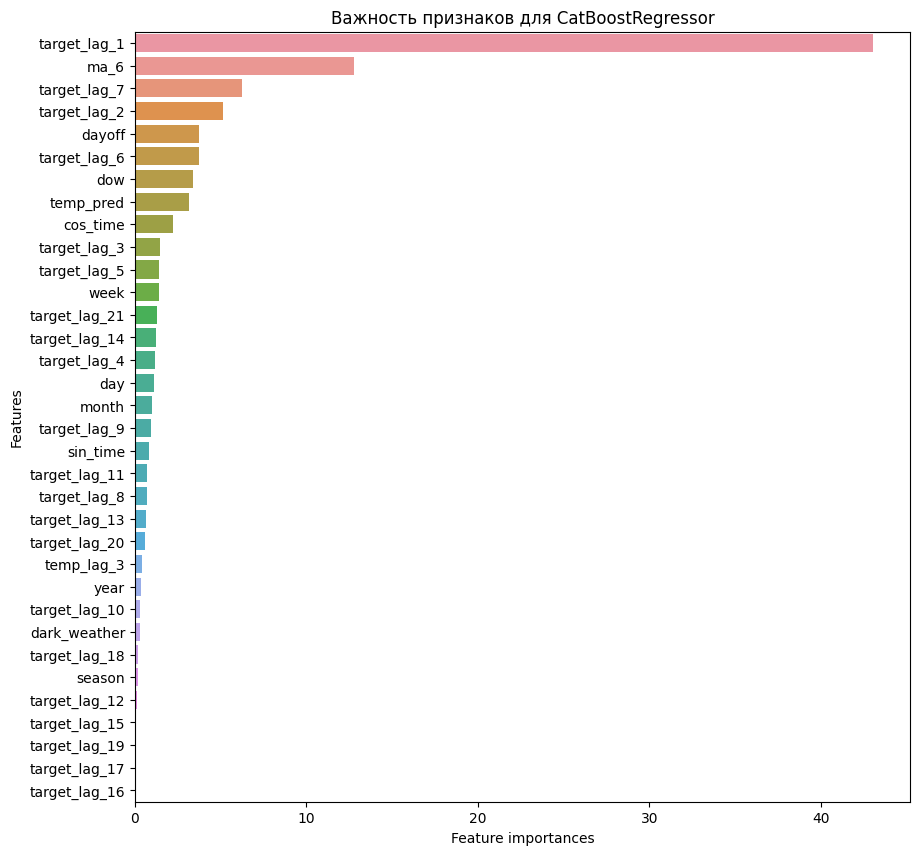

In [36]:
# Посмотрим на важность признаков для CatBoostRegressor

cb_feat_imp = cb.get_feature_importance(prettified=True)

plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=cb_feat_imp['Importances'], y=cb_feat_imp['Feature Id'])
ax.set_title('Важность признаков для CatBoostRegressor')
ax.set_yticklabels(cb_feat_imp['Feature Id'])
ax.set_xlabel('Feature importances')
ax.set_ylabel('Features')
plt.show()

In [38]:
# Протестируем лучшую модель

preds = cb.predict(features_test)
preds = pd.DataFrame({'y_pred': preds, 'date': test['date']})
preds_grouped = preds.groupby('date')['y_pred'].sum()
y_test = pd.DataFrame({'y_test': target_test, 'date': test['date']})
y_test_grouped = y_test.groupby('date')['y_test'].sum()
test_mae = mean_absolute_error(y_test_grouped, preds_grouped)
test_mae

127.0971873241459

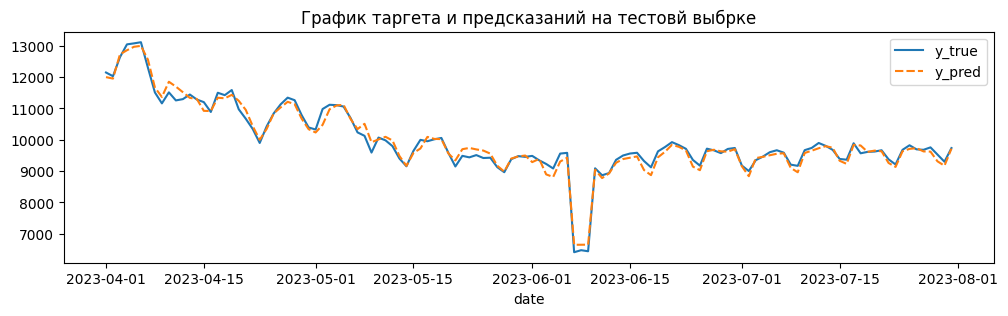

In [40]:
plot_df = pd.DataFrame({'date': test['date'].unique(), 'y_true': y_test_grouped, 'y_pred': preds_grouped})

fig, ax = plt.subplots(figsize=(12, 3))
g = sns.lineplot(data=plot_df)
plt.title('График таргета и предсказаний на тестовой выборке')
plt.show()